In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_group: "02_12_24_WMH_BinningInf"
    
calibration:
    num_bins: 15
    square_diff: False 
    neighborhood_width: 3
    metric_cfg_file: "/storage/vbutoi/projects/ESE/ese/experiment/configs/inference/Calibration_Metrics.yaml"

options:
    load_pixel_meters: False 
    remove_shared_columns: False
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    add_baseline_rows: True 
    equal_rows_per_cfg_assert: False 
    min_fg_pixels: 100

<IPython.core.display.Javascript object>

In [3]:
from ese.experiment.analysis.analyze_inf import load_cal_inference_stats

image_info_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=True
)

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


Finished loading inference stats.
Log amounts: log.root                                                                                      log_set                                              
/storage/vbutoi/scratch/ESE/inference/02_12_24_WMH_Inference/WMH_Ensemble_HistogramBinning    20240212_220553-6TFP-7378d1c559ebc7362691352f1864d8cc    13282
                                                                                              20240212_220555-YD9T-ac7ae3fd5ffb719ee6c6d0da6e114cd3    13282
                                                                                              20240212_220559-NN49-d431216c711cacb9c08586d5034868f6    13282
                                                                                              20240212_220602-ZW7N-f296da2f4ee3b4587f1ae547b6ae5760    13282
                                                                                              20240212_220605-OBE9-e805d82d0c85fbab6fc0349fe3ad645c    13282
                    

In [4]:
image_info_df.keys()

Index(['data_id', 'split', 'slice_idx', 'image_metric', 'metric_score',
       'groupavg_image_metric', 'groupavg_metric_score', 'num_bins',
       'neighborhood_width', 'square_diff', 'num_lab_0_pixels',
       'num_lab_1_pixels', 'ECE', 'Edge-ECE', 'CW-ECE', 'ECW-ECE',
       'Uniform-CW-ECE', 'Uniform-ECW-ECE', 'ELM', 'Edge-ELM', 'Uniform-ELM',
       'Uniform-Edge-ELM', 'Foreground-CW-ECE', 'Foreground-ECW-ECE',
       'Uniform-Foreground-CW-ECE', 'Uniform-Foreground-ECW-ECE', 'log_set',
       'calibration.neighborhood_width', 'calibration.num_bins',
       'calibration.square_diff', 'data.preload', 'data.slicing',
       'data.splits', 'dataloader.batch_size', 'dataloader.num_workers',
       'dataloader.pin_memory', 'dataset._class', 'dataset.annotator',
       'dataset.axis', 'dataset.num_slices', 'dataset.preload',
       'dataset.return_data_id', 'dataset.slicing', 'dataset.task',
       'dataset.version', 'experiment.dataset_name', 'experiment.exp_root',
       'experiment.p

In [5]:
image_info_df['calibrator'].unique()

array(['Uncalibrated', 'Histogram_Binning (norm)', 'Histogram_Binning',
       'NECTAR_Scaling', 'NECTAR_Binning (norm)', 'NECTAR_Binning'],
      dtype=object)

## We are going to remove the case where there are very few pixels, cause unrealistic outliers.

In [6]:
# Sort the image_info_df by method name, so everything appears nicely
image_info_df = image_info_df.sort_values(by=['method_name', 'calibrator'])
# Make sure that the model_class 'Uncalibrated' is first
image_info_df['calibrator'] = image_info_df['calibrator'].astype('category')
image_info_df['calibrator'] = image_info_df['calibrator'].cat.reorder_categories([
    'Uncalibrated',
    # 'Vanilla',
    # 'Temperature_Scaling', 
    # 'Vector_Scaling', 
    # 'Dirichlet_Scaling',
    # 'LTS', 
    'NECTAR_Scaling',
    'Histogram_Binning',
    'Histogram_Binning (norm)',
    'NECTAR_Binning',
    'NECTAR_Binning (norm)'
])

In [7]:
image_info_df['method_name'].unique()

array(['Average UNet', 'Ensemble (mean, logits)',
       'Ensemble (mean, probs)', 'Ensemble (product, probs)',
       'UNet (seed=40)', 'UNet (seed=41)', 'UNet (seed=42)',
       'UNet (seed=43)'], dtype=object)

In [8]:
image_info_df['ensemble_w_metric'].unique()

array([nan, 'None'], dtype=object)

In [9]:
# Select only the rows corresponding to group methods
image_info_df = image_info_df[image_info_df['model_type'] == 'group']

image_info_df['method_name'] = image_info_df['method_name'].astype('category')
image_info_df['method_name'] = image_info_df['method_name'].cat.reorder_categories([
    'Average UNet',
    'Ensemble (mean, logits)', 
    'Ensemble (mean, probs)', 
    'Ensemble (product, probs)', 
    # 'UNet (seed=40)', 
    # 'UNet (seed=41)', 
    # 'UNet (seed=42)', 
    # 'UNet (seed=43)', 
    ])

image_info_df['split'] = image_info_df['split'].astype('category')
image_info_df['split'] = image_info_df['split'].cat.reorder_categories([
    'val',
    'cal'
])

# image_info_df['ensemble_w_metric'] = image_info_df['ensemble_w_metric'].astype('category')
# image_info_df['ensemble_w_metric'] = image_info_df['ensemble_w_metric'].cat.reorder_categories([
#     'None',
#     'val-loss',
#     'val-dice_score',
#     'val-ece_loss',
#     'val-elm_loss'
# ])

# Let's looks at the calibration scores of our models.

## ECE Metrics

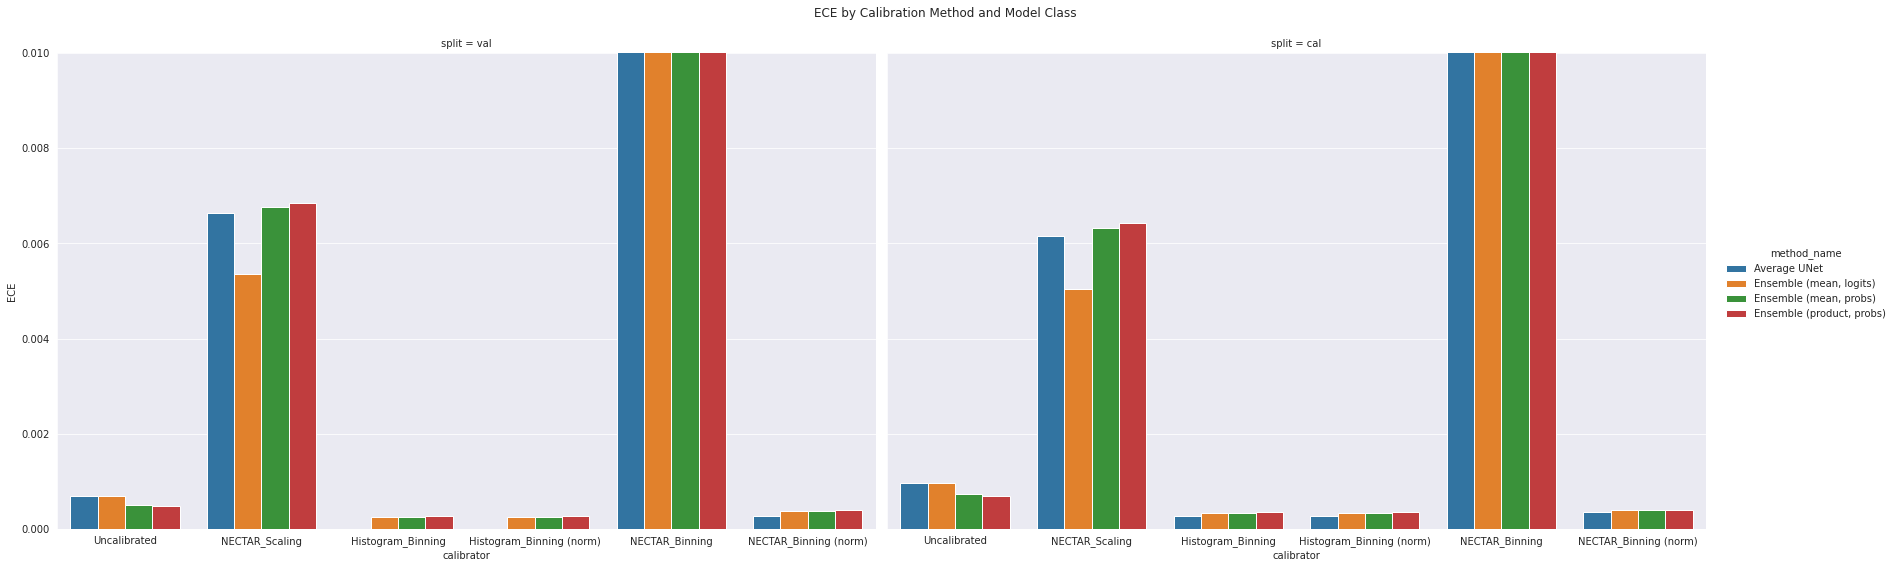

In [10]:
g = sns.catplot(
    data=image_info_df,
    x="calibrator",
    y="ECE",
    hue="method_name",
    col="split",
    kind="bar",
    height=8,
    aspect=1.5
)
# Set column spacingj
# Set the title of the plot
g.set(ylim=(0.0, 0.01))
g.fig.suptitle("ECE by Calibration Method and Model Class")
# Move the title slightly up
g.fig.subplots_adjust(top=0.9)

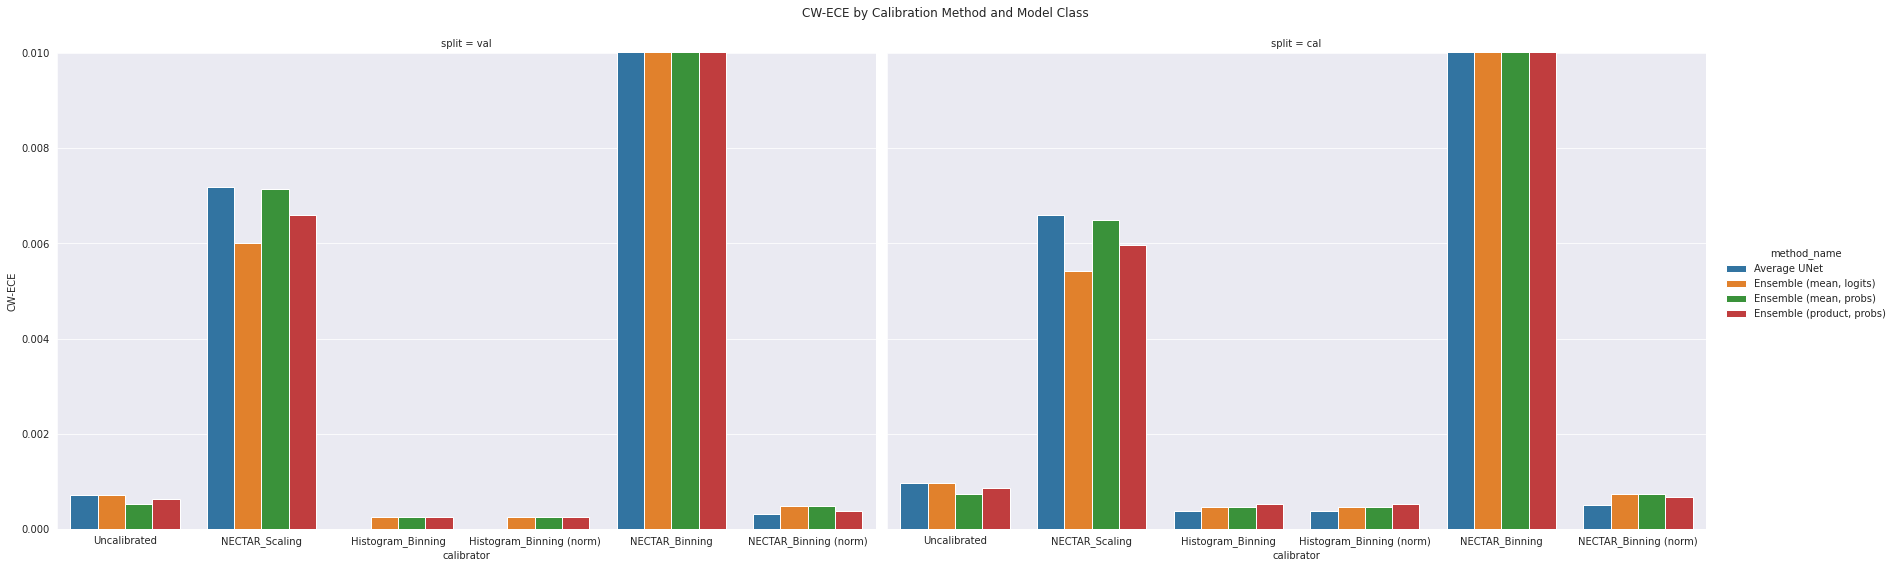

In [11]:
g = sns.catplot(
    data=image_info_df,
    x="calibrator",
    y="CW-ECE",
    hue="method_name",
    col="split",
    kind="bar",
    height=8,
    aspect=1.5
)
# Set column spacing
# # Set the y-axis limits
g.set(ylim=(0.0, 0.01))
g.fig.suptitle("CW-ECE by Calibration Method and Model Class")
# Move the title slightly up
g.fig.subplots_adjust(top=0.9)

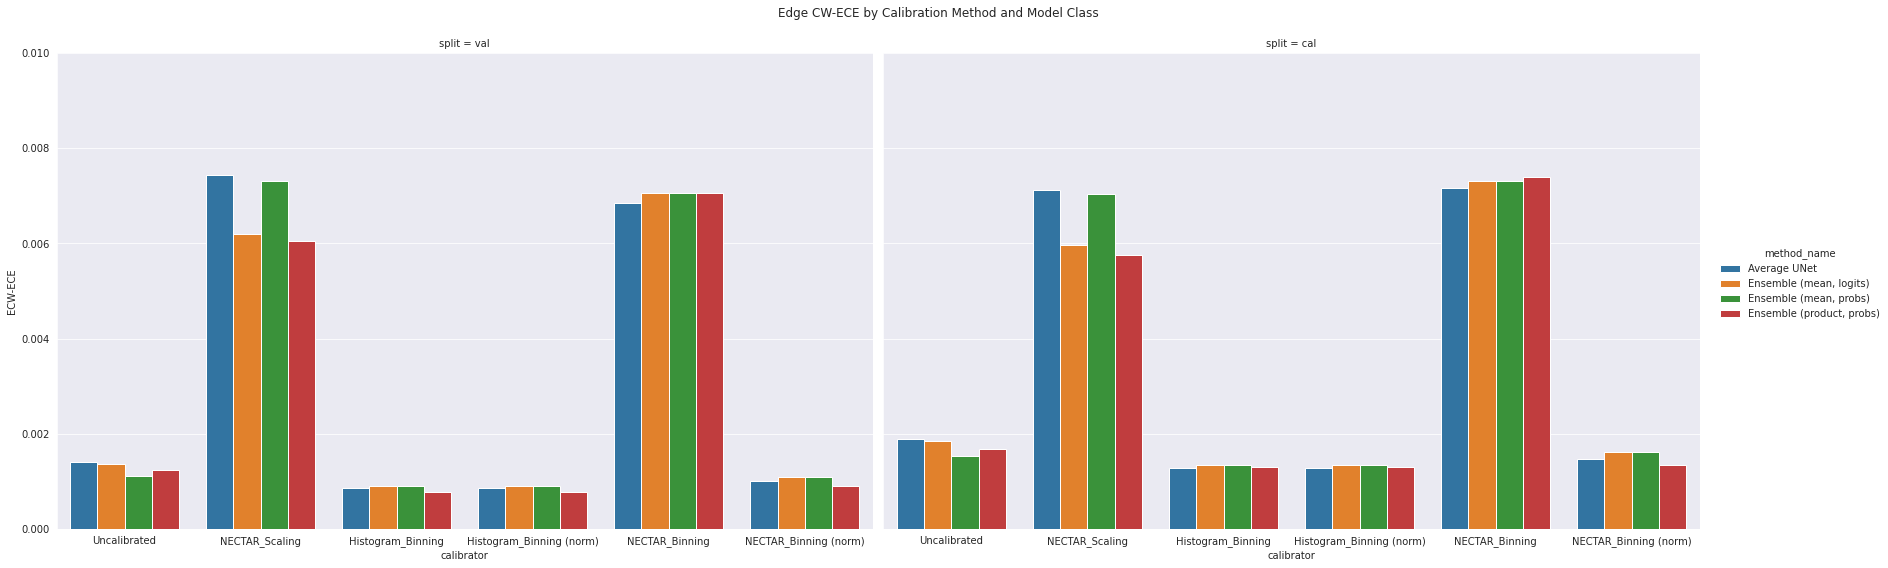

In [12]:
g = sns.catplot(
    data=image_info_df,
    x="calibrator",
    y="ECW-ECE",
    hue="method_name",
    col="split",
    kind="bar",
    height=8,
    aspect=1.5
)
# Set column spacing
# # Set the y-axis limits
g.set(ylim=(0.0, 0.01))
g.fig.suptitle("Edge CW-ECE by Calibration Method and Model Class")
# Move the title slightly up
g.fig.subplots_adjust(top=0.9)

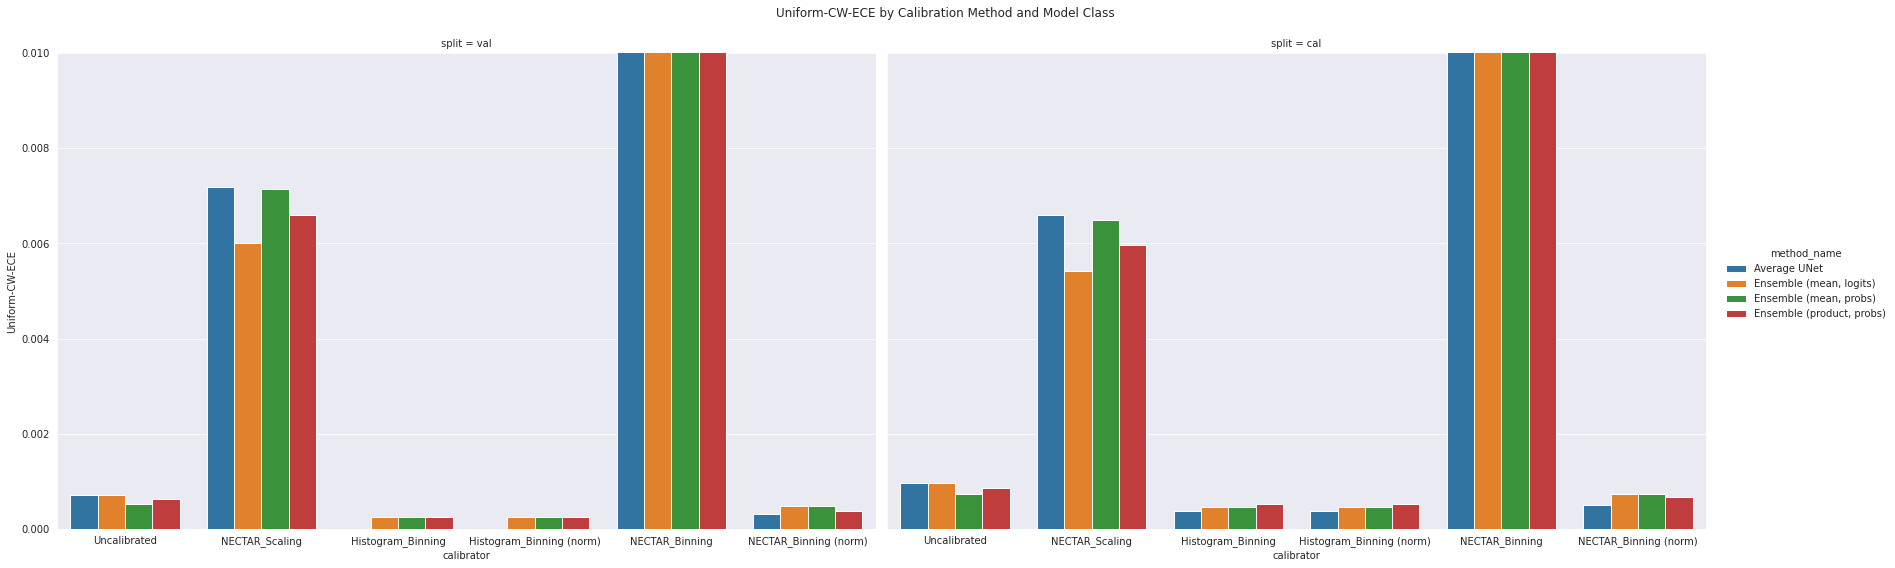

In [13]:
g = sns.catplot(
    data=image_info_df,
    x="calibrator",
    y="Uniform-CW-ECE",
    hue="method_name",
    col="split",
    kind="bar",
    height=8,
    aspect=1.5
)
# Set column spacing
# # Set the y-axis limits
g.set(ylim=(0.0, 0.01))
g.fig.suptitle("Uniform-CW-ECE by Calibration Method and Model Class")
# Move the title slightly up
g.fig.subplots_adjust(top=0.9)

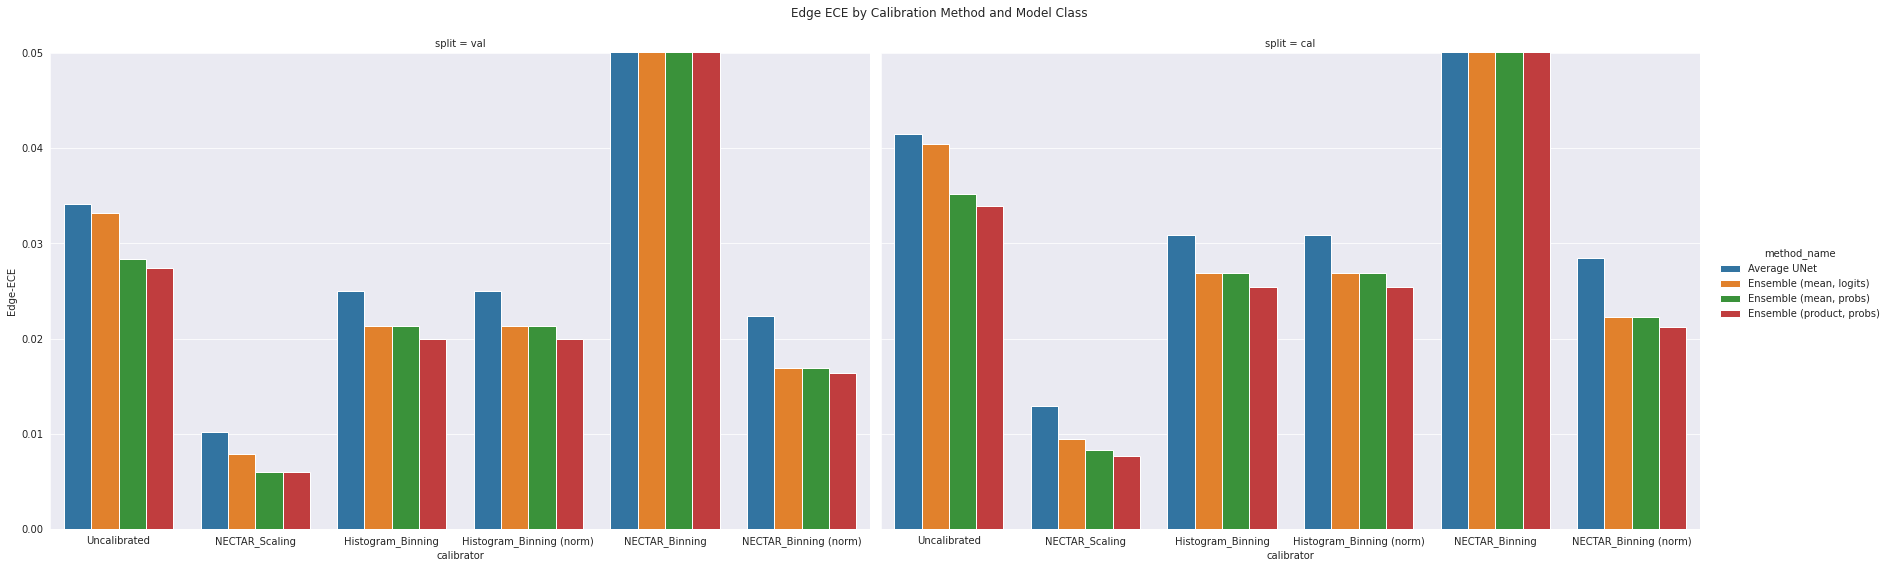

In [14]:
g = sns.catplot(
    data=image_info_df,
    x="calibrator",
    y="Edge-ECE",
    hue="method_name",
    kind="bar",
    col="split",
    height=8,
    aspect=1.5
)
# Set column spacing
# # Set the y-axis limits
g.set(ylim=(0.0, 0.05))
g.fig.suptitle("Edge ECE by Calibration Method and Model Class")
# Move the title slightly up
g.fig.subplots_adjust(top=0.9)

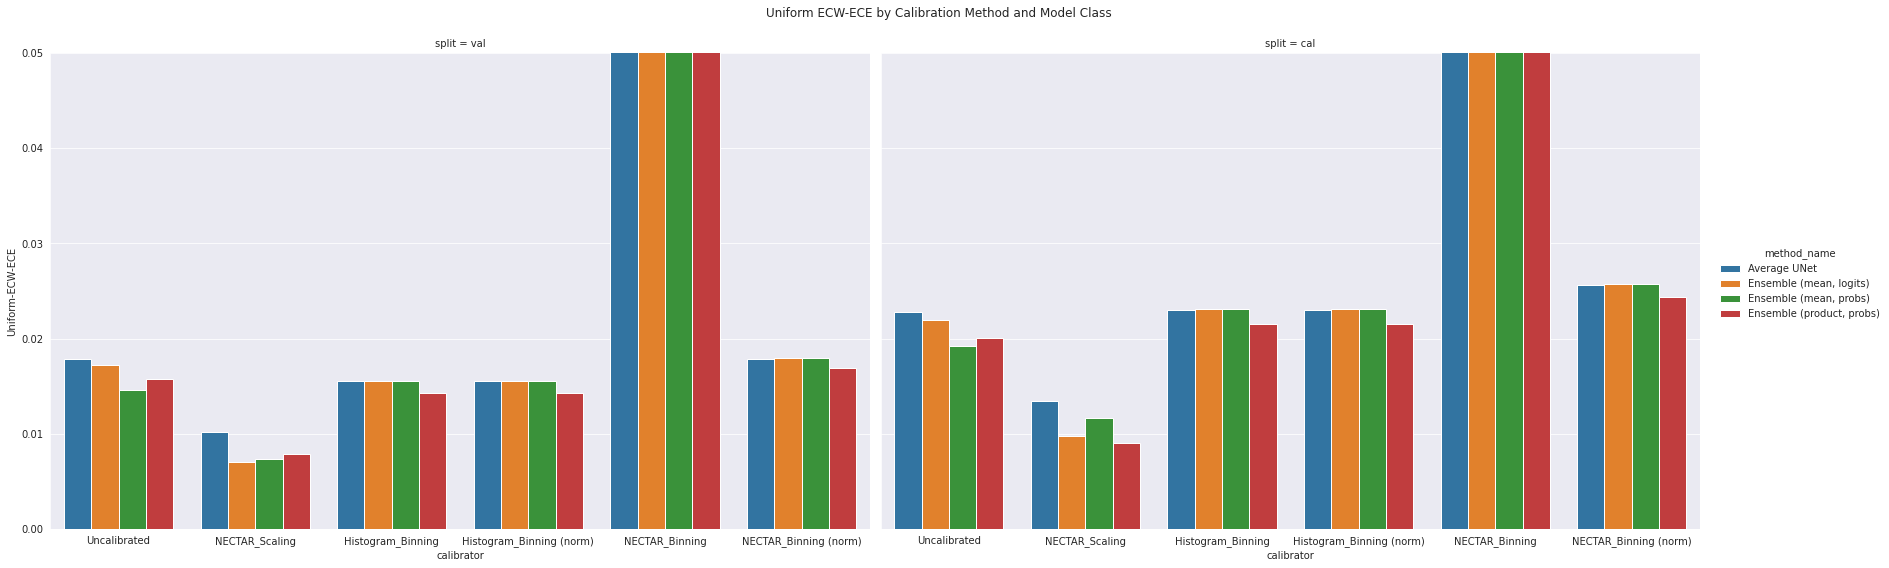

In [15]:
g = sns.catplot(
    data=image_info_df,
    x="calibrator",
    y="Uniform-ECW-ECE",
    hue="method_name",
    kind="bar",
    col="split",
    height=8,
    aspect=1.5
)
# Set column spacing
# # Set the y-axis limits
g.set(ylim=(0.0, 0.05))
g.fig.suptitle("Uniform ECW-ECE by Calibration Method and Model Class")
# Move the title slightly up
g.fig.subplots_adjust(top=0.9)

## ELM Metrics

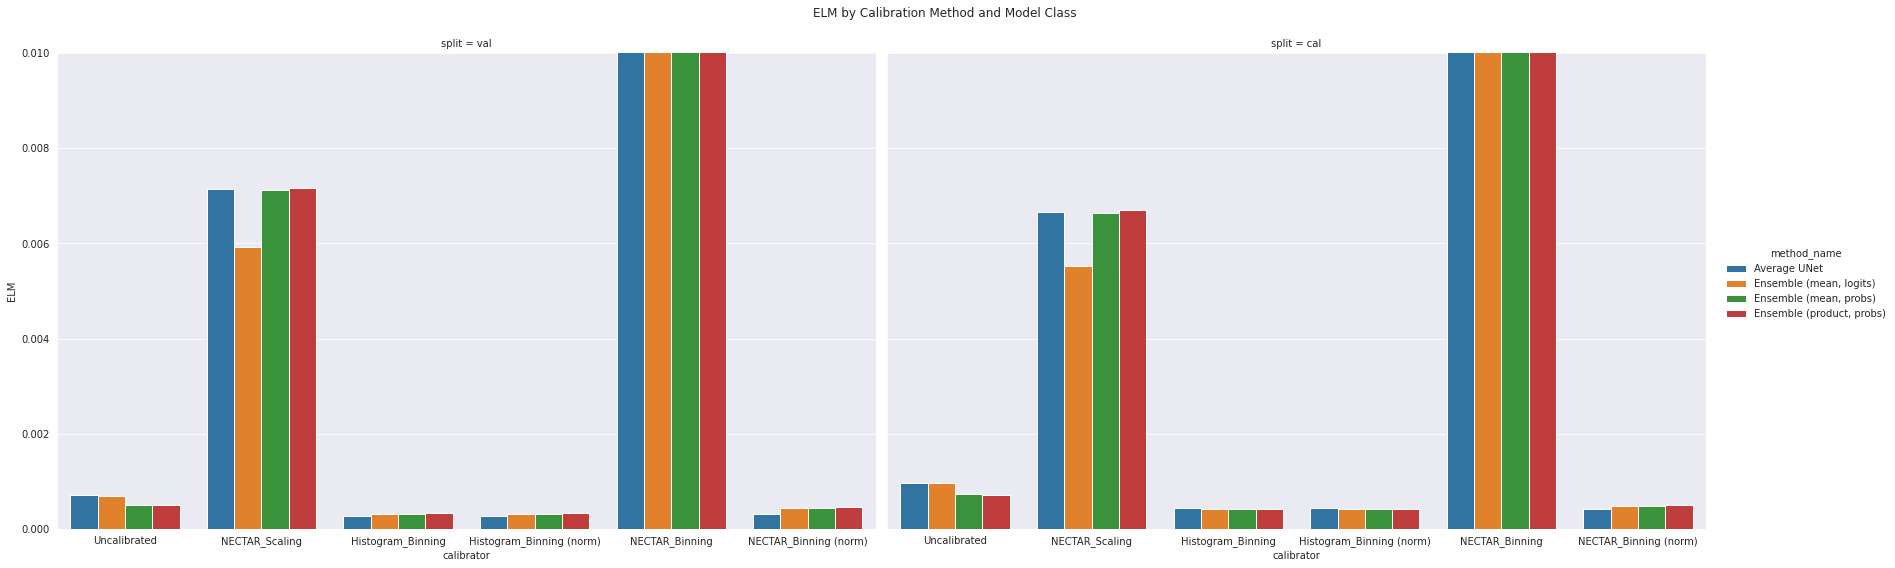

In [16]:
g = sns.catplot(
    data=image_info_df,
    x="calibrator",
    y="ELM",
    hue="method_name",
    kind="bar",
    col="split",
    height=8,
    aspect=1.5
)
# Set column spacing
# # Set the y-axis limits
g.set(ylim=(0.0, 0.01))
g.fig.suptitle("ELM by Calibration Method and Model Class")
# Move the title slightly up
g.fig.subplots_adjust(top=0.9)

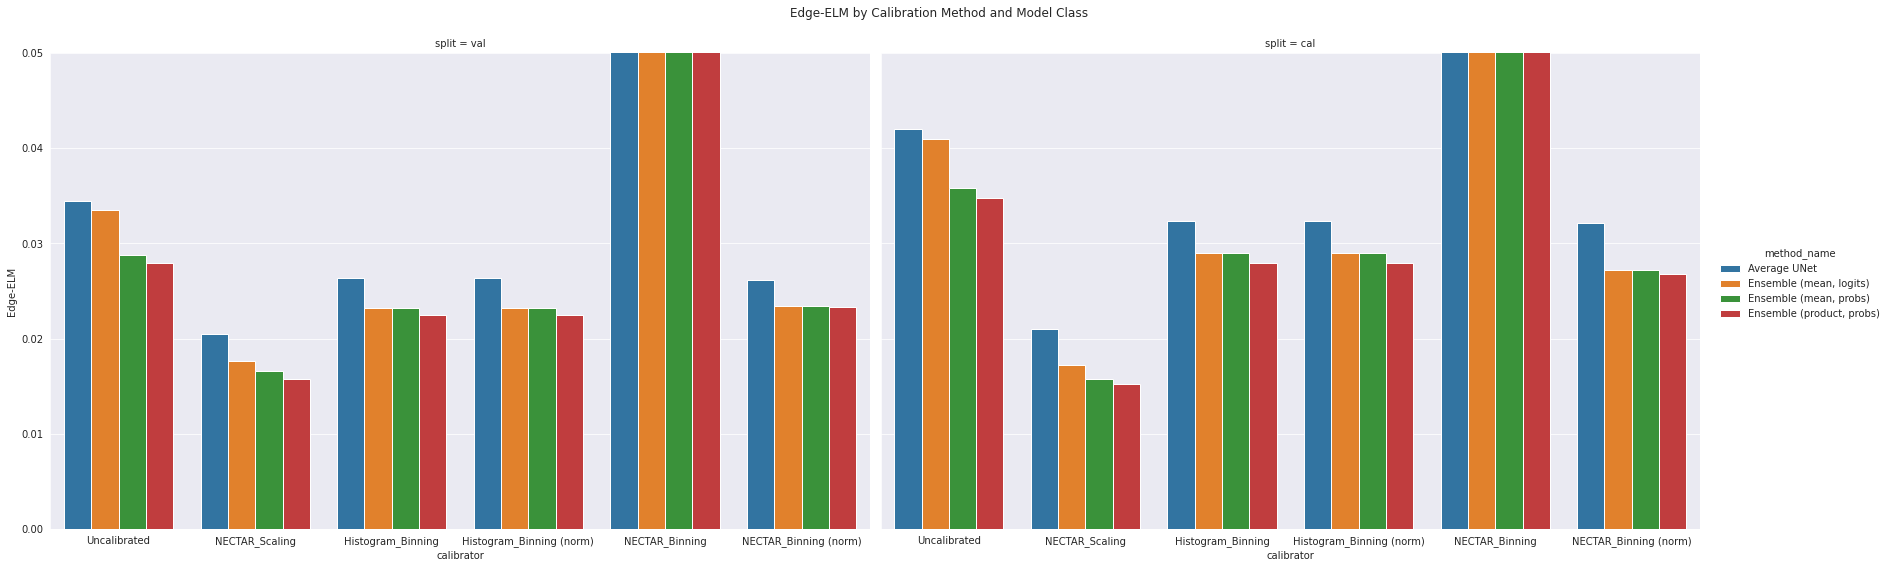

In [17]:
g = sns.catplot(
    data=image_info_df,
    x="calibrator",
    y="Edge-ELM",
    hue="method_name",
    kind="bar",
    col="split",
    height=8,
    aspect=1.5
)
# Set column spacing
# # Set the y-axis limits
g.set(ylim=(0.0, 0.05))
g.fig.suptitle("Edge-ELM by Calibration Method and Model Class")
# Move the title slightly up
g.fig.subplots_adjust(top=0.9)

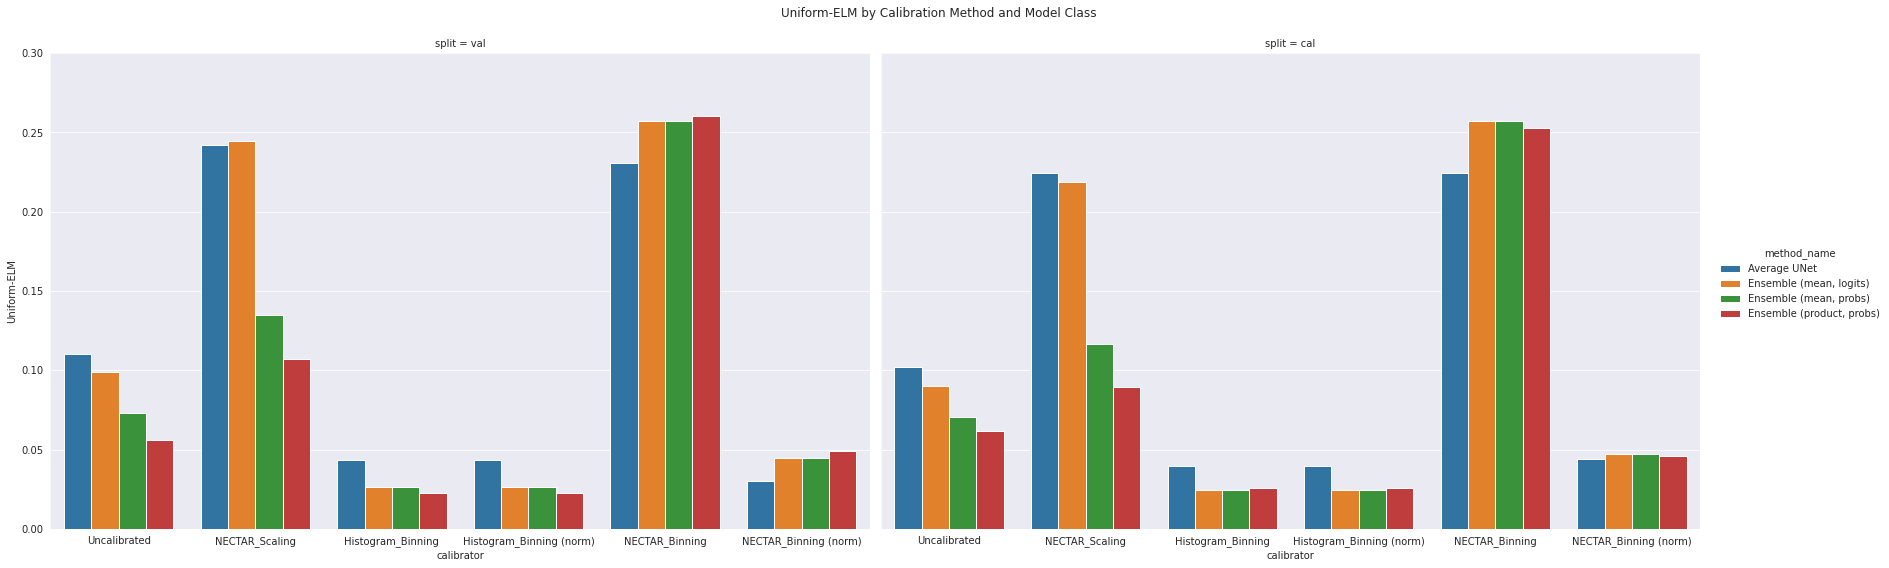

In [18]:
g = sns.catplot(
    data=image_info_df,
    x="calibrator",
    y="Uniform-ELM",
    hue="method_name",
    kind="bar",
    col="split",
    height=8,
    aspect=1.5
)
# Set column spacing
# # Set the y-axis limits
g.set(ylim=(0.0, 0.3))
g.fig.suptitle("Uniform-ELM by Calibration Method and Model Class")
# Move the title slightly up
g.fig.subplots_adjust(top=0.9)

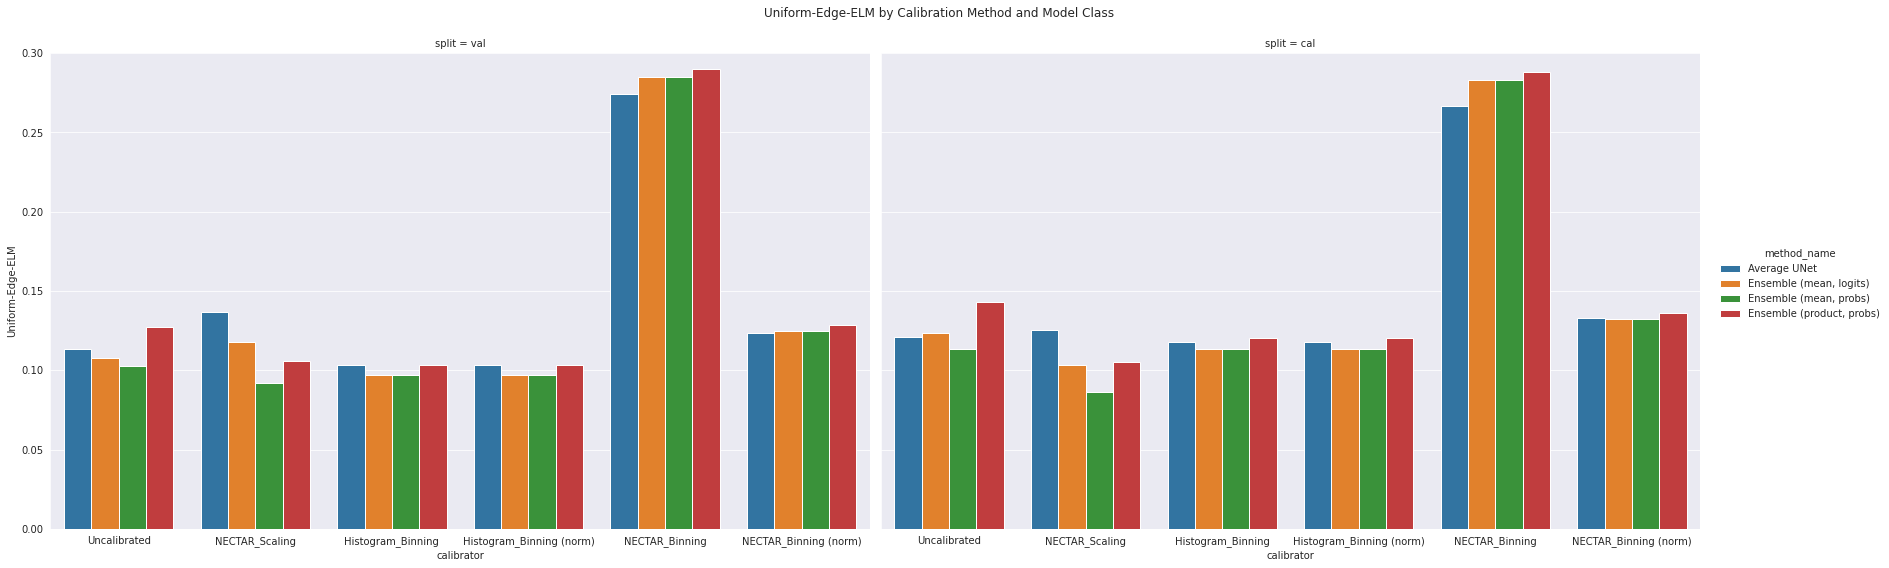

In [19]:
g = sns.catplot(
    data=image_info_df,
    x="calibrator",
    y="Uniform-Edge-ELM",
    hue="method_name",
    kind="bar",
    col="split",
    height=8,
    aspect=1.5
)
# Set column spacing
# # Set the y-axis limits
g.set(ylim=(0.0, 0.3))
g.fig.suptitle("Uniform-Edge-ELM by Calibration Method and Model Class")
# Move the title slightly up
g.fig.subplots_adjust(top=0.9)

## Now we can look at the quality averages themselves, first looking slice-wise.

In [20]:
image_info_df["image_metric"].unique()

array(['BoundaryIOU', 'Dice', 'HD95', 'Image_CW-ECE', 'Image_ECE',
       'Image_ECW-ECE', 'Image_ELM', 'Image_Edge-ECE', 'Image_Edge-ELM',
       'Image_Foreground-CW-ECE', 'Image_Foreground-ECW-ECE',
       'Image_Uniform-CW-ECE', 'Image_Uniform-ECW-ECE',
       'Image_Uniform-ELM', 'Image_Uniform-Edge-ELM',
       'Image_Uniform-Foreground-CW-ECE',
       'Image_Uniform-Foreground-ECW-ECE', 'Dice Loss'], dtype=object)

In [21]:
table_df = image_info_df.groupby(["method_name", "calibrator", "image_metric", "ensemble"])['metric_score'].mean().reset_index()
dice_table = image_info_df[image_info_df["image_metric"] == "Dice"]
dice_loss_table = image_info_df[image_info_df["image_metric"] == "Dice Loss"]
hd95_table = image_info_df[image_info_df["image_metric"] == "HD95"]
boundaryiou_table = image_info_df[image_info_df["image_metric"] == "BoundaryIOU"]

In [22]:
# Load the pickled df corresponding to the upper-bound of the uncalibrated UNets
from ese.experiment.analysis.analysis_utils.inference_utils import load_upperbound_df 

# Fill the column corresponding to slice_idx with string 'None'
upperbound_df = load_upperbound_df(results_cfg['log'])

Error loading upperbound df: [Errno 2] No such file or directory: '/storage/vbutoi/scratch/ESE/inference/02_12_24_WMH_BinningInf/ensemble_upper_bounds/'


In [23]:

if upperbound_df is not None:
    dice_ub_df = upperbound_df[upperbound_df["image_metric"] == "Dice"]
    dice_loss_ub_df = upperbound_df[upperbound_df["image_metric"] == "Dice Loss"]
    hd95_ub_df = upperbound_df[upperbound_df["image_metric"] == "HD95"]
    boundaryiou_df = upperbound_df[upperbound_df["image_metric"] == "BoundaryIOU"]
    # De Nan the dice_ub_df
    dice_ub_df = dice_ub_df[dice_ub_df['metric_score'].notna()]
    dice_loss_ub_df = dice_loss_ub_df[dice_loss_ub_df['metric_score'].notna()]
    hd95_ub_df = hd95_ub_df[hd95_ub_df['metric_score'].notna()]
    boundaryiou_df = boundaryiou_df[boundaryiou_df['metric_score'].notna()]

In [24]:
upperbound_df

In [25]:
log_inference_group = results_cfg['log']['inference_group']

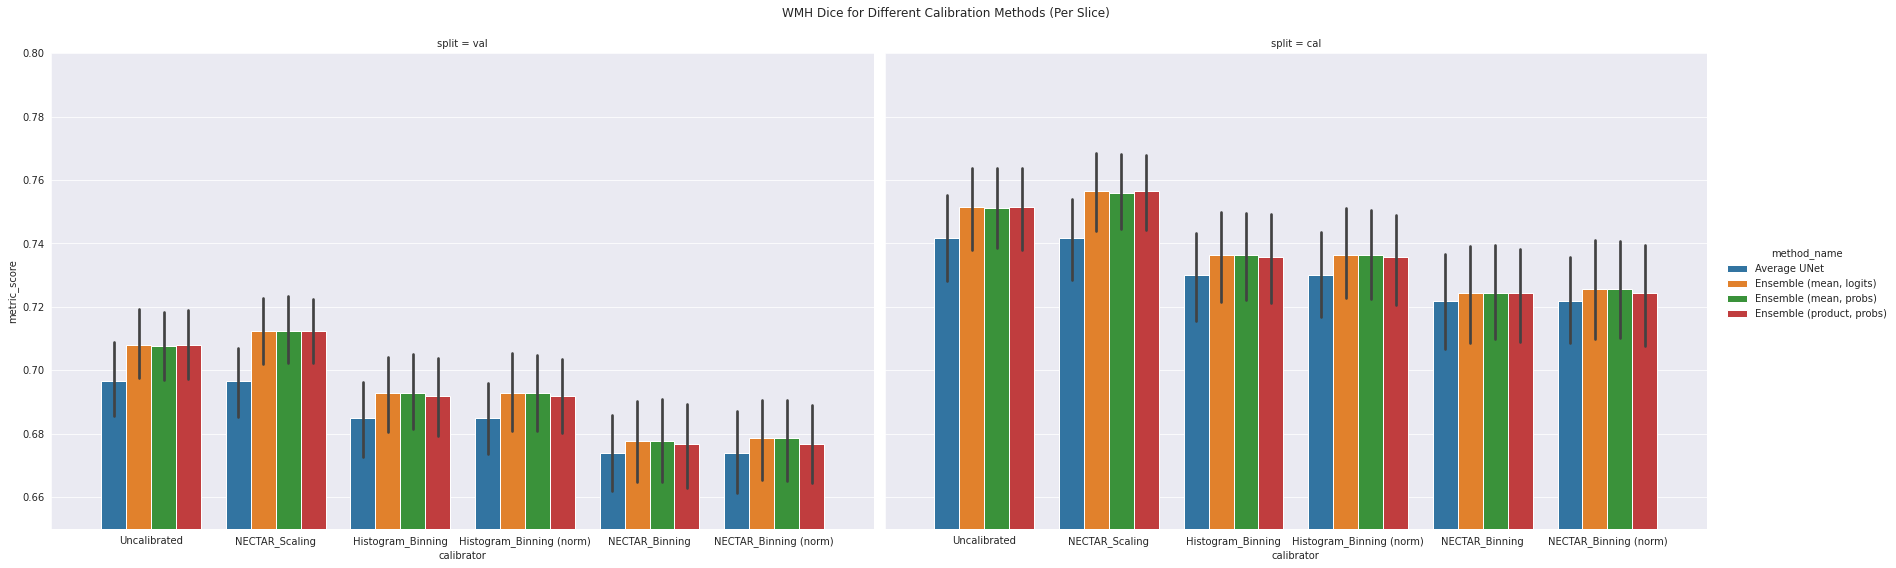

In [26]:
from ese.experiment.analysis.analysis_utils.plot_utils import plot_upperbound_line

if "WMH" in log_inference_group:
    g = sns.catplot(
        data=dice_table,
        x="calibrator",
        y="metric_score",
        hue="method_name",
        col="split",
        kind="bar",
        height=8,
        aspect=1.5
    )
    num_calibrators = len(image_info_df['calibrator'].unique())
    if upperbound_df is not None:
        plot_upperbound_line(
            graph=g, 
            plot_df=dice_ub_df, 
            y="metric_score", 
            num_calibrators=num_calibrators, 
            col="split"
        )
    # Set the title of the bar plot
    g.fig.suptitle("WMH Dice for Different Calibration Methods (Per Slice)")
    # Give the title a bit of spacing from the plot
    g.fig.subplots_adjust(top=0.90)
    # Set the y axis to be between 0.5 and 1.0
    calibrators_width = num_calibrators - 1
    g.set(xlim=(-0.8, calibrators_width + 0.8))
    g.set(ylim=(0.65, 0.8))

In [27]:
from ese.experiment.analysis.analysis_utils.plot_utils import plot_upperbound_line

if "CityScapes" in log_inference_group:
    g = sns.catplot(
        data=dice_table,
        x="calibrator",
        y="metric_score",
        hue="method_name",
        kind="bar",
        col="split",
        height=8,
        aspect=1.5
    )
    num_calibrators = len(image_info_df['calibrator'].unique())
    if upperbound_df is not None:
        plot_upperbound_line(
            graph=g, 
            plot_df=dice_ub_df, 
            y="metric_score", 
            num_calibrators=num_calibrators, 
            col="split"
        )
    # Set the title of the bar plot
    g.fig.suptitle("CityScapes Dice for Different Calibration Methods")
    # Give the title a bit of spacing from the plot
    g.fig.subplots_adjust(top=0.90)
    # Set the y axis to be between 0.5 and 1.0
    calibrators_width = num_calibrators - 1
    g.set(xlim=(-0.8, calibrators_width + 0.8))
    g.set(ylim=(0.65, 0.80))

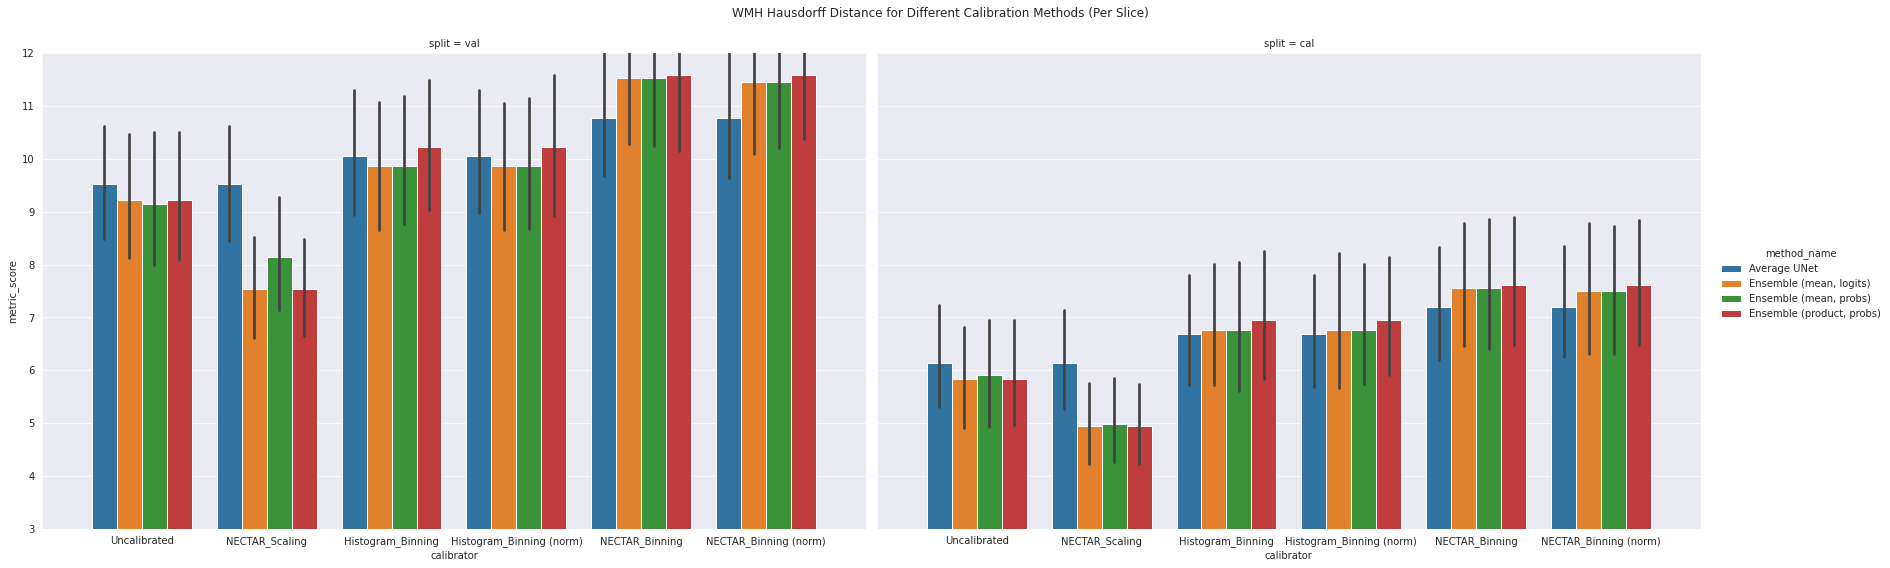

In [28]:
from ese.experiment.analysis.analysis_utils.plot_utils import plot_upperbound_line

if "WMH" in log_inference_group:
    g = sns.catplot(
        data=hd95_table,
        x="calibrator",
        y="metric_score",
        hue="method_name",
        col="split",
        kind="bar",
        height=8,
        aspect=1.5
    )
    num_calibrators = len(image_info_df['calibrator'].unique())
    if upperbound_df is not None:
        plot_upperbound_line(
            graph=g, 
            plot_df=hd95_ub_df, 
            y="metric_score", 
            num_calibrators=num_calibrators, 
            col="split"
        )
    # Set the title of the bar plot
    g.fig.suptitle("WMH Hausdorff Distance for Different Calibration Methods (Per Slice)")
    # Give the title a bit of spacing from the plot
    g.fig.subplots_adjust(top=0.90)
    # Set the y axis to be between 0.5 and 1.0
    calibrators_width = num_calibrators - 1
    g.set(xlim=(-0.8, calibrators_width + 0.8))
    g.set(ylim=(3.0, 12))

In [29]:
from ese.experiment.analysis.analysis_utils.plot_utils import plot_upperbound_line

if "CityScapes" in log_inference_group:
    g = sns.catplot(
        data=hd95_table,
        x="calibrator",
        y="metric_score",
        hue="method_name",
        kind="bar",
        col="split",
        height=8,
        aspect=1.5
    )
    num_calibrators = len(image_info_df['calibrator'].unique())
    if upperbound_df is not None:
        plot_upperbound_line(
            graph=g, 
            plot_df=hd95_ub_df, 
            y="metric_score", 
            num_calibrators=num_calibrators, 
            col="split"
        )
    # Set the title of the bar plot
    g.fig.suptitle("CityScapes Hausdorff Distance for Different Calibration Methods")
    # Give the title a bit of spacing from the plot
    g.fig.subplots_adjust(top=0.90)
    # Set the y axis to be between 0.5 and 1.0
    calibrators_width = num_calibrators - 1
    g.set(xlim=(-0.8, calibrators_width + 0.8))
    g.set(ylim=(27, 52))

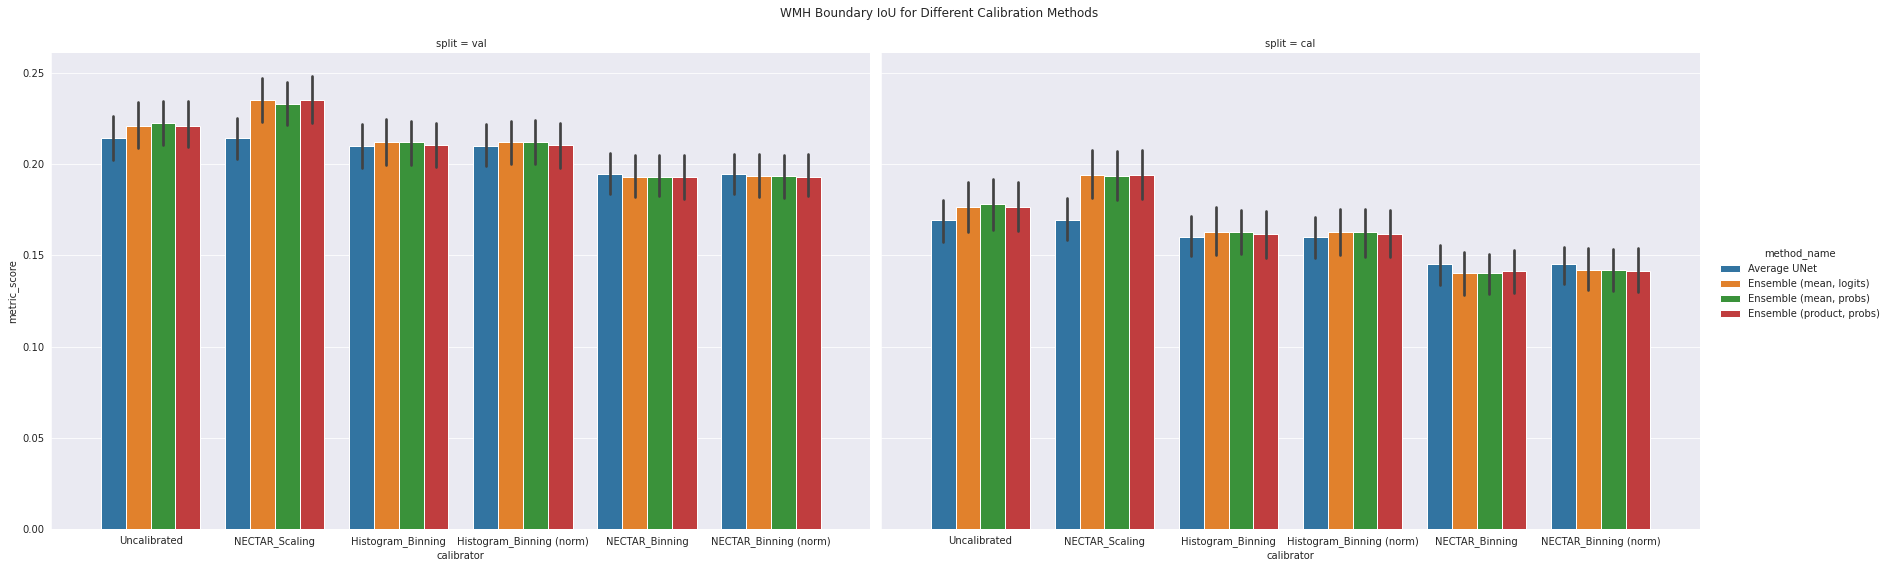

In [30]:
from ese.experiment.analysis.analysis_utils.plot_utils import plot_upperbound_line

if "WMH" in log_inference_group:
    g = sns.catplot(
        data=boundaryiou_table,
        x="calibrator",
        y="metric_score",
        hue="method_name",
        col="split",
        kind="bar",
        height=8,
        aspect=1.5
    )
    num_calibrators = len(image_info_df['calibrator'].unique())
    if upperbound_df is not None:
        plot_upperbound_line(
            graph=g, 
            plot_df=boundaryiou_df, 
            y="metric_score", 
            num_calibrators=num_calibrators, 
            col="split"
        )
    # Set the title of the bar plot
    g.fig.suptitle("WMH Boundary IoU for Different Calibration Methods")
    # Give the title a bit of spacing from the plot
    g.fig.subplots_adjust(top=0.90)
    # Set the y axis to be between 0.5 and 1.0
    calibrators_width = num_calibrators - 1
    g.set(xlim=(-0.8, calibrators_width + 0.8))
    # g.set(ylim=(0.20, 0.35))

In [31]:
from ese.experiment.analysis.analysis_utils.plot_utils import plot_upperbound_line

if "CityScapes" in log_inference_group:
    g = sns.catplot(
        data=boundaryiou_table,
        x="calibrator",
        y="metric_score",
        hue="method_name",
        kind="bar",
        col="split",
        height=8,
        aspect=1.5
    )
    num_calibrators = len(image_info_df['calibrator'].unique())
    if upperbound_df is not None:
        plot_upperbound_line(
            graph=g, 
            plot_df=boundaryiou_df, 
            y="metric_score", 
            num_calibrators=num_calibrators, 
            col="split"
        )
    # Set the title of the bar plot
    g.fig.suptitle("CityScapes Boundary IoU for Different Calibration Methods")
    # Give the title a bit of spacing from the plot
    g.fig.subplots_adjust(top=0.90)
    # Set the y axis to be between 0.5 and 1.0
    calibrators_width = num_calibrators - 1
    g.set(xlim=(-0.8, calibrators_width + 0.8))
    g.set(ylim=(0.0, 0.01))